In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [3]:
cd "/root/SymmNeRF/"

/root/SymmNeRF


In [6]:
from opt import config_parser
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import setproctitle

parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:0")
det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 0
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'

args.no_load_opt = True

setproctitle.setproctitle('[Gaetan - SymmNeRF VIT]')

In [22]:
# Create training dataset
from torch.utils.data import DataLoader
from datasets import dataset_dict, create_training_dataset
import matplotlib.pyplot as plt 

train_dataset, train_sampler = create_training_dataset(args)
train_loader = DataLoader(train_dataset, batch_size= 1,#args.batch_size,
                              worker_init_fn=lambda _: np.random.seed(),
                              num_workers=args.workers,
                              pin_memory=False,
                              sampler=train_sampler,
                              shuffle=True if train_sampler is None else False)

[Info] Training dataset: srns_dataset
[Info] Set used: train
SRNsDataset:  /data/datasets/srn_cars/cars_train


In [25]:
from model import model_dict
from model.projection import Projector 
from model.sample_ray import RaySampler
from model.render_ray import render_rays, get_intermediate_visuals
from skimage.metrics import peak_signal_noise_ratio as PSNR
import tqdm 

In [28]:
# Create the ViT based model.
args.with_vit = True
args.archCNN = 'resnet18_light'

model_vit = model_dict[args.model](args, '')

# Create the baseline model.
args.with_vit = False
args.archCNN = 'resnet34'
model_baseline = model_dict[args.model](args, '')


# Create the projector
projector = Projector(device)

Value of with_vit: True
[Info] No ckpts found, training from scratch...
Value of with_vit: False
[Info] No ckpts found, training from scratch...


In [29]:
# Create criterion
criterion = torch.nn.MSELoss()

# Symmetry matrix
M = torch.tensor([[-1.,0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]]).to(device)

# Data to overfit on.
it = iter(train_loader)
train_data = next(it)

# Load training rays
ray_sampler = RaySampler(train_data)

In [37]:
I_target_list = []
I_source_list = []
I_pred_vit_list = []
I_pred_baseline_list = []


for global_step in tqdm.tqdm(range(5000)):
       
        
    ray_batch = ray_sampler.random_sample(args.N_rand,device, use_bbox=(global_step <= args.no_bbox_step))

    z_vit,feat_cnn_vit,feat_vit_vit = model_vit.encode(ray_batch['src_img'])
    z_baseline,feat_cnn_baseline,feat_vit_baseline = model_baseline.encode(ray_batch['src_img'])


    # Feature concatenation.
    featmap_vit = torch.cat([feat_cnn_vit,feat_vit_vit],1)
    featmap_baseline = feat_cnn_baseline
    
    ret_vit = render_rays(ray_batch = ray_batch,
                          model = model_vit,
                          device = device,
                          featmap = featmap_vit,
                          latent_vector = z_vit,
                          projector = projector,
                          N_samples = args.N_samples,
                          M = M, 
                          enforceSymm = args.enforce_symmetry,
                          lindisp = args.lindisp,
                          N_importance = args.N_importance,
                          det = args.det,
                          raw_noise_std = args.raw_noise_std,
                          white_bkgd = args.white_bkgd)
    
    ret_baseline = render_rays(ray_batch = ray_batch,
                          model = model_baseline,
                          device = device,
                          featmap = featmap_baseline,
                          latent_vector = z_baseline,
                          projector = projector,
                          N_samples = args.N_samples,
                          M = M, 
                          enforceSymm = args.enforce_symmetry,
                          lindisp = args.lindisp,
                          N_importance = args.N_importance,
                          det = args.det,
                          raw_noise_std = args.raw_noise_std,
                          white_bkgd = args.white_bkgd)
    
            
    # Compute loss
    model_vit.optimizer.zero_grad()
    model_baseline.optimizer.zero_grad()
    

    loss_vit = criterion(ret_vit['outputs_coarse']['rgb'], ray_batch['rgb']) + criterion(ret_vit['outputs_fine']['rgb'], ray_batch['rgb'])
    loss_baseline = criterion(ret_baseline['outputs_coarse']['rgb'], ray_batch['rgb']) + criterion(ret_baseline['outputs_fine']['rgb'], ray_batch['rgb'])
   
    loss_vit.backward()
    model_vit.optimizer.step()
    
    loss_baseline.backward()
    model_baseline.optimizer.step()
        
    
    if global_step % 500 == 0:
            

            render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
            render_list.remove(ray_sampler.src_view[0])
            render_view = np.random.choice(render_list, 1)[0]

            gt_img = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
            src_img = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)

            rgb_pred_vit = get_intermediate_visuals(args,model_vit,projector,M,device,ray_sampler,render_view)
            rgb_pred_baseline = get_intermediate_visuals(args,model_baseline,projector,M,device,ray_sampler,render_view)
            
            It = gt_img.numpy()
            Is = src_img.numpy()
            Ifine_vit = rgb_pred_vit.numpy()
            Ifine_baseline = rgb_pred_baseline.numpy()
            
            I_target_list.append(It)
            I_source_list.append(Is)
            I_pred_vit_list.append(Ifine_vit)
            I_pred_baseline_list.append(Ifine_baseline)
            
            psnr_vit = PSNR(It,Ifine_vit)
            psnr_baseline = PSNR(It,Ifine_baseline)
            print(f'Loss vit: {loss_vit} - Loss baseline: {loss_baseline}')
            print(f'PSNR ViT: {psnr_vit} - PSNR baseline: {psnr_baseline}')
            

  0%|          | 1/5000 [00:06<8:20:00,  6.00s/it]

Loss vit: 0.13810914754867554 - Loss baseline: 0.2891885042190552
PSNR ViT: 14.743531545687091 - PSNR baseline: 7.227758875005001


 10%|█         | 501/5000 [03:34<2:39:33,  2.13s/it]

Loss vit: 0.020262278616428375 - Loss baseline: 0.019584227353334427
PSNR ViT: 24.987005384476145 - PSNR baseline: 25.182828739424835


 20%|██        | 1001/5000 [07:03<2:20:23,  2.11s/it]

Loss vit: 0.0200201328843832 - Loss baseline: 0.022168945521116257
PSNR ViT: 25.287025868445387 - PSNR baseline: 26.017913651061015


 30%|███       | 1501/5000 [10:31<2:02:21,  2.10s/it]

Loss vit: 0.018191803246736526 - Loss baseline: 0.01780613884329796
PSNR ViT: 26.98705060370922 - PSNR baseline: 27.042807239912854


 40%|████      | 2001/5000 [14:00<1:45:49,  2.12s/it]

Loss vit: 0.013572655618190765 - Loss baseline: 0.015728868544101715
PSNR ViT: 27.123731842560534 - PSNR baseline: 27.214963593527457


 50%|█████     | 2501/5000 [17:29<1:28:07,  2.12s/it]

Loss vit: 0.01766536943614483 - Loss baseline: 0.016511311754584312
PSNR ViT: 27.655973716436876 - PSNR baseline: 27.429546758788483


 60%|██████    | 3001/5000 [20:58<1:10:20,  2.11s/it]

Loss vit: 0.01635310798883438 - Loss baseline: 0.013371733948588371
PSNR ViT: 26.548276484887058 - PSNR baseline: 28.753990639997188


 70%|███████   | 3501/5000 [24:25<52:08,  2.09s/it]  

Loss vit: 0.018305018544197083 - Loss baseline: 0.017245851457118988
PSNR ViT: 28.73094715059544 - PSNR baseline: 29.472493928801534


 80%|████████  | 4001/5000 [27:52<34:43,  2.09s/it]

Loss vit: 0.011080384254455566 - Loss baseline: 0.010476488620042801
PSNR ViT: 29.796598019609846 - PSNR baseline: 29.95546011244002


 90%|█████████ | 4501/5000 [31:20<17:25,  2.09s/it]

Loss vit: 0.01471637561917305 - Loss baseline: 0.013457003980875015
PSNR ViT: 27.157041215790727 - PSNR baseline: 27.411245679677275


100%|██████████| 5000/5000 [34:41<00:00,  2.40it/s]


In [38]:
render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
render_list.remove(ray_sampler.src_view[0])
render_view = np.random.choice(render_list, 1)[0]

gt_img = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
src_img = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)

rgb_pred_vit = get_intermediate_visuals(args,model_vit,projector,M,device,ray_sampler,render_view)
rgb_pred_baseline = get_intermediate_visuals(args,model_baseline,projector,M,device,ray_sampler,render_view)
            
It = gt_img.numpy()
Is = src_img.numpy()
Ifine_vit = rgb_pred_vit.numpy()
Ifine_baseline = rgb_pred_baseline.numpy()
            
I_target_list.append(It)
I_source_list.append(Is)
I_pred_vit_list.append(Ifine_vit)
I_pred_baseline_list.append(Ifine_baseline)
            
psnr_vit = PSNR(It,Ifine_vit)
psnr_baseline = PSNR(It,Ifine_baseline)
print(f'Loss vit: {loss_vit} - Loss baseline: {loss_baseline}')
print(f'PSNR ViT: {psnr_vit} - PSNR baseline: {psnr_baseline}')

Loss vit: 0.008937052451074123 - Loss baseline: 0.009479139000177383
PSNR ViT: 27.993803279767867 - PSNR baseline: 28.417527054669826


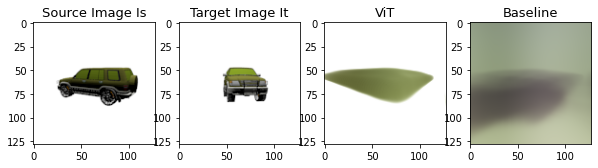

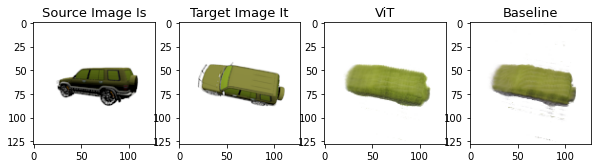

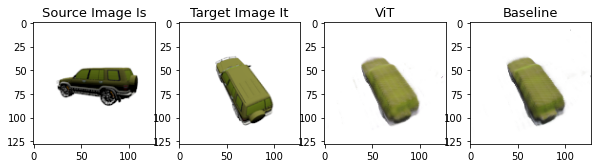

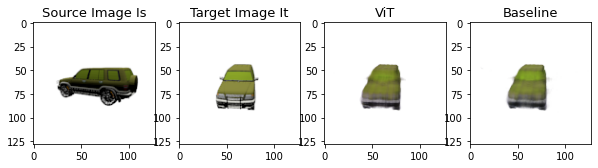

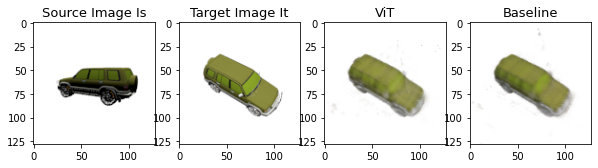

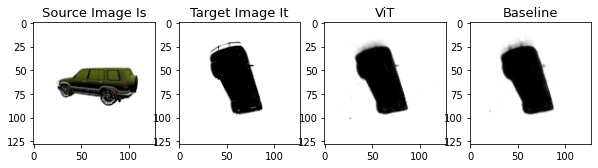

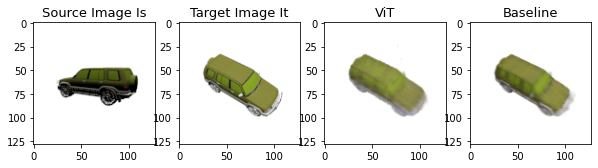

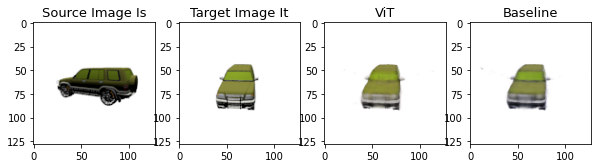

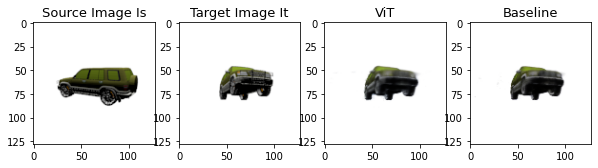

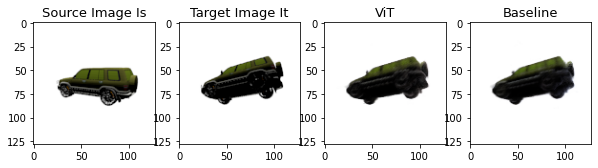

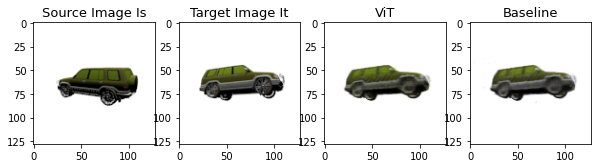

In [39]:
nb_imgs = len(I_target_list)

for i in range(nb_imgs):
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 10))

    It = I_target_list[i]
    Is = I_source_list[i]
    Ipred_vit = I_pred_vit_list[i]
    Ipred_baseline = I_pred_baseline_list[i]
    
    ax1.imshow(Is)
    ax2.imshow(It)
    ax3.imshow(Ipred_vit)
    ax4.imshow(Ipred_baseline)
            
    ax1.set_title('Source Image Is', fontsize=13)
    ax2.set_title('Target Image It', fontsize=13)
    ax3.set_title('ViT', fontsize=13)
    ax4.set_title('Baseline',fontsize=13)
            
    plt.show()

In [22]:
from model.feature_network import ResNetVision
import torch 
model = ResNetVision(features=256)
x = torch.zeros([1,3,128,128])

y = model(x)

Groups:1 - base_width: 64
Groups:1 - base_width: 64
Groups:1 - base_width: 64


In [23]:
print(y.shape)

torch.Size([1, 128, 64, 64])
